In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import brentq, fsolve, least_squares
from scipy.interpolate import interp2d
from scipy.integrate import quad
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

In [39]:
ois_disc_factor = pd.read_excel('Data_1_Output.xlsx', sheet_name='oisDiscFactors')['DiscountFactor']
libor_disc_factor = pd.read_excel('Data_1_Output.xlsx', sheet_name='liborDiscFactors')['DiscountFactor']
fwd_swap_rates = pd.read_excel('Data_1_Output.xlsx', sheet_name='fwdSwapRates')['liborForwardSwapRate']
start = pd.read_excel('Data_1_Output.xlsx', sheet_name='fwdSwapRates')['Start'].apply(lambda x: x.rstrip('Y')).copy()
tenor = pd.read_excel('Data_1_Output.xlsx', sheet_name='fwdSwapRates')['Tenor'].apply(lambda x: x.rstrip('Y')).copy()
pvbp = pd.read_excel('Data_2_output.xlsx', sheet_name='PVBP')
sabr_results = pd.read_excel('Data_2_output.xlsx', sheet_name='SABR_Results')
dd_results = pd.read_excel('Data_2_output.xlsx', sheet_name='DD_Results')

In [40]:
#CMS10Y discount factors semi annualy 5 years (slicing original discount factors 10 of 60)
# not inclusive of d(0,0)
cms10y = []
cms2y = []
interp_cms2y = []
interp_libor = []
tenor_index = []

cms10y = ois_disc_factor[:10]
# cms10y

cms2y = ois_disc_factor[:20]
cms2y = np.insert(cms2y,0,1)

for i in range(0,len(cms2y) - 1):
    interp_cms2y.append((cms2y[i] + cms2y[i+1])/2)
    interp_cms2y.append(cms2y[i+1])

for i in range(0,len(libor_disc_factor[:31]) - 1):
    interp_libor.append((libor_disc_factor[i] + libor_disc_factor[i+1])/2)
    interp_libor.append(libor_disc_factor[i+1])


num_samples = int(1 + (15 - 0.5) / 0.5)
linspace_index = np.linspace(0.5, 15, num=num_samples)

# interp_cms2y.append(cms2y[21])
cmsdiscfactors = pd.DataFrame({"Tenor":pd.Series(linspace_index),
                               "CMS10Y":pd.Series(cms10y),
                               "Libor":pd.Series(libor_disc_factor)})

num_samples = int(1 + (20 - 0.25) / 0.25)
linspace_index = np.linspace(0.25, 20, num=num_samples)

cmsdiscfactors_2y = pd.DataFrame({"Tenor":pd.Series(linspace_index),
                                  "CMS2Y":pd.Series(interp_cms2y),
                                  "Libor":pd.Series(interp_libor)})

cmsdiscfactors_2y

,Tenor,CMS2Y,Libor
0,0.25,1.000000,0.993827
1,0.50,1.000000,0.987654
2,0.75,0.999376,0.980116
3,1.00,0.998752,0.972577
4,1.25,0.997880,0.964977
...,...,...,...
75,19.00,NaN,NaN
76,19.25,NaN,NaN
77,19.50,NaN,NaN
78,19.75,NaN,NaN


For static replication of any constant maturity swap (CMS) payoff $g(F)$, where $F$ is the swap rate, we use the following formula:

  \begin{equation*}
    \begin{split}
      V_0 &= D(0,T) g(F) + h'(F)[V^{pay}(F)-V^{rec}(F)] \\
      &\;\;\;\;\;\;\;\;\;\;+ \int_0^F h''(K) V^{rec}(K) dK +
      \int_F^\infty h''(K) V^{pay}(K) dK
    \end{split}
  \end{equation*}

where

  \begin{equation*}
    \begin{split}
      h(K) &= \frac{g(K)}{\mbox{IRR}(K)} \\
      h'(K) &= \frac{\mbox{IRR}(K)g'(K) - g(K)\mbox{IRR}'(K)}{\mbox{IRR}(K)^2} \\
      h''(K) &= \frac{\mbox{IRR}(K)g''(K)-\mbox{IRR}''(K)g(K) -2\cdot\mbox{IRR}'(K)g'(K)}{\mbox{IRR}(K)^2} \\
      &\;\;\;\;\;\;\;\;\;\;+
      \frac{2\cdot\mbox{IRR}'(K)^2g(K)}{\mbox{IRR}(K)^3}.
    \end{split}
  \end{equation*}
  
For CMS rate payoff, the payoff function can be defined simply as $g(F)=F$, and the static replication formula simplifies into:

  \begin{equation*}
    \begin{split}
      D(0,T) F + \int_0^F h''(K) V^{rec}(K) dK + \int_F^\infty h''(K) V^{pay}(K) dK
    \end{split}
  \end{equation*}

We can implement this in Python. First we define the IRR functions.

Let $m$ denote the payment frequenc ($m=2$ for semi-annual payment frequency), and let $N = T_N-T_n$ denote the tenor of the swap (number of years), the partial derivatives on the IRR function $\mbox{IRR}(S)$ given by:
\begin{equation*}
\begin{split}
\mbox{IRR}(K)&=\sum_{i=1}^{N\times m}\frac{1}{(1+\frac{K}{m})^i}=\frac{1}{K}\left[1-\frac{1}{\left(1+\frac{K}{m}\right)^{N\times m}}\right]\\
\mbox{IRR}'(K)&=-\frac{1}{K}\mbox{IRR}(K)
+\frac{1}{m\times K}\frac{N\times m}{\left(1+\frac{K}{m}\right)^{N\times m+1}} \\
\mbox{IRR}''(K)&=-\frac{2}{K}\mbox{IRR}'(K)
-\frac{1}{m^2\times K}\frac{N\times m\cdot (N\times m+1)}{\left(1+\frac{K}{m}\right)^{N\times m+2}} \\
\end{split}
\end{equation*}

These results will need to be generalised to handle the case for $m=2$ to be consistent with the semi-annual payment frequency swap market data provided.


In [41]:
def IRR_0(K, m, N):
    # implementation of IRR(K) function
    value = 1/K * ( 1.0 - 1/(1 + K/m)**(N*m) )
    return value

def IRR_1(K, m, N):
    # implementation of IRR'(K) function (1st derivative)
    firstDerivative = -1/K*IRR_0(K, m, N) + 1/(K*m)*N*m/(1+K/m)**(N*m+1)
    return firstDerivative

def IRR_2(K, m, N):
    # implementation of IRR''(K) function (2nd derivative)
    secondDerivative = -2/K*IRR_1(K, m, N) - 1/(K*m*m)*(N*m)*(N*m+1)/(1+K/m)**(N*m+2)
    return secondDerivative


For CMS rate payment, since $g(F)=F$, we have the derivatives:

\begin{equation*}
\begin{split}
g(K) &= K \\
g'(K) &= 1 \\
g''(K) &= 0
\end{split}
\end{equation*}

In [42]:
def g_0(K):
    return K

def g_1(K):
    return 1.0

def g_2(K):
    return 0.0

The function $h(K) = g(K)/IRR(K)$ now simplies into:  
  
  \begin{equation*}
    \begin{split}
      h(K) &= \frac{g(K)}{\mbox{IRR}(K)} \\
      h'(K) &= \frac{\mbox{IRR}(K)g'(K) - g(K)\mbox{IRR}'(K)}{\mbox{IRR}(K)^2} \\
      h''(K) &= \frac{\mbox{IRR}(K)g''(K)-\mbox{IRR}''(K)g(K) -2\cdot\mbox{IRR}'(K)g'(K)}{\mbox{IRR}(K)^2} \\
      &\;\;\;\;\;\;\;\;\;\;+
      \frac{2\cdot\mbox{IRR}'(K)^2g(K)}{\mbox{IRR}(K)^3}.
    \end{split}
  \end{equation*}


In [43]:
def h_0(K, m, N):
    # implementation of h(K)
    value = g_0(K) / IRR_0(K, m, N)
    return value

def h_1(K, m, N):
    # implementation of h'(K) (1st derivative)
    firstDerivative = (IRR_0(K, m, N)*g_1(K) - g_0(K)*IRR_1(K, m, N)) / IRR_0(K, m, N)**2
    return firstDerivative

def h_2(K, m, N):
    # implementation of h''(K) (2nd derivative)
    secondDerivative = ((IRR_0(K, m, N)*g_2(K) - IRR_2(K, m, N)*g_0(K) - 2.0*IRR_1(K, m, N)*g_1(K))/IRR_0(K, m, N)**2
                        + 2.0*IRR_1(K, m, N)**2*g_0(K)/IRR_0(K, m, N)**3)
    return secondDerivative

We will also need to implement the IRR-settled payer and receiver swaption formulae:

  \begin{equation*}
    \begin{split}
      V^{pay}_{n,N}(0) &= D(0,T_n) \cdot \mbox{IRR}(S_{n,N}(0)) \cdot \mbox{Black76Call}(S_{n,N}(0),K,\sigma_{n,N},T) \\
      V^{rec}_{n,N}(0) &= D(0,T_n) \cdot \mbox{IRR}(S_{n,N}(0)) \cdot \mbox{Black76Put}(S_{n,N}(0),K,\sigma_{n,N},T) \\
    \end{split}
  \end{equation*}

where $S_{n,N}(0)=F$ is today's forward swap rate calculated based on the curves we bootstrapped, and $\sigma_{n,N}$ is the SABR implied volatility calibrated to swaption market data.

In [44]:
def calculateBlackCall(S, K, T, sigma, pvbp):
    d1 = (np.log(S/K)+ 0.5*(sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    blackCallPrice = pvbp * (S*norm.cdf(d1) - K*norm.cdf(d2))
    return blackCallPrice

def calculateBlackPut(S, K, T, sigma, pvbp):
    d1 = (np.log(S/K)+0.5*(sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    blackPutPrice = pvbp * (K*norm.cdf(-d2) - S*norm.cdf(-d1))
    return blackPutPrice

def SABR(F, K, T, alpha, rho, nu, beta):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

In [45]:
def integrand1(x,m,e,t,F,alpha,rho,nu,pvbp):
    h = h_2(x,m,t)
    sigma = SABR(F,F,e,alpha,rho,nu,0.9)
    Vrec = IRR_0(F,m,t)*calculateBlackPut(F,x,e,sigma,pvbp)
    return h*Vrec

def integrand2(x,m,e,t,F,alpha,rho,nu,pvbp):
    h = h_2(x,e,t)
    sigma = SABR(F,F,e,alpha,rho,nu,0.9)
    Vpay = IRR_0(F,m,t)*calculateBlackCall(F,x,e,sigma,pvbp)
    return h*Vpay

In [46]:
CMSrates = []

for i in range(len(pvbp['PVBP'])):
    F = fwd_swap_rates[i]

    #         pvbp = 0.5 * sum(discountFactors.OIS[2*ex_int:(ex_int+te_int)*2])
    pvbp_1 = 1

    alpha = sabr_results['Alpha'][i]
    rho = sabr_results['Rho'][i]
    nu = sabr_results['Nu'][i]

    freq = 1

    integral1, error1 = quad(lambda x : integrand1(x,freq,int(start[i]),int(tenor[i]),F,alpha,rho,nu,pvbp_1), 0, F)
    integral2, error2 = quad(lambda x : integrand2(x,freq,int(start[i]),int(tenor[i]),F,alpha,rho,nu,pvbp_1), F, np.inf)

    CMSrates.append(F + integral1 + integral2)

In [47]:
pv_cms_10x5 = pd.DataFrame(columns=['Expiry','Tenor','ForwardRate','Alpha','Rho','Nu','CMSRate'])

In [48]:
def CalculateForwardRate(discountFactors,short,long):
    i = 1
    for short in short:
        forwardRate = \
            (discountFactors[discountFactors.Tenor == short].Libor.values[0] - \
             discountFactors[discountFactors.Tenor == long+short].Libor.values[0]) \
            /(discountFactors[discountFactors.Tenor == long+short].Libor.values[0] * long)

        pv_cms_10x5.loc[i,'Expiry'] = short
        pv_cms_10x5.loc[i,'Tenor'] = long
        pv_cms_10x5.loc[i,'ForwardRate'] = forwardRate
        i+=1

### PV of a leg receiving CMS10y semi-annually over the next 5 years

In [49]:
#PV of a leg receiving CMS10y semi-annually over the next 5 years
short = [0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ]
long = 10.0
CalculateForwardRate(cmsdiscfactors,short,long)

In [50]:
columns = ['1Y', '2Y', '3Y', '5Y', '10Y']
index = ['1Y', '5Y', '10Y']

alpha_df = pd.DataFrame(columns=columns, index=index)
rho_df = pd.DataFrame(columns=columns, index=index)
nu_df = pd.DataFrame(columns=columns, index=index)

for df,results in zip([alpha_df,rho_df,nu_df],[sabr_results['Alpha'],sabr_results['Rho'],sabr_results['Nu']]):
    i = 0
    for ind in index:
        for c in columns:
            df.loc[ind,c] = results[i]
            i+=1
alpha_df

,1Y,2Y,3Y,5Y,10Y
1Y,0.139065,0.184646,0.196851,0.178046,0.171009
5Y,0.166505,0.199232,0.209696,0.187755,0.172283
10Y,0.17626,0.194721,0.20234,0.189969,0.181609


In [51]:
expiries = np.array([1, 5, 10])
tenors = np.array([1, 2, 3, 5, 10])

#alpha, rho and nu
def interpolate_sabr_parameters(short, long, tenors, expiries):
    i=1
    for t in short:
        f_linear_alpha = interp2d(tenors, expiries, alpha_df, kind='linear')
        f_linear_rho = interp2d(tenors, expiries, rho_df, kind='linear')
        f_linear_nu = interp2d(tenors, expiries, nu_df, kind='linear')
        interpolated_alpha_linear = f_linear_alpha(long, t)
        interpolated_rho_linear = f_linear_rho(long, t)
        interpolated_nu_linear = f_linear_nu(long, t)

        pv_cms_10x5.loc[i,'Alpha'] = interpolated_alpha_linear[0]
        pv_cms_10x5.loc[i,'Rho'] = interpolated_rho_linear[0]
        pv_cms_10x5.loc[i,'Nu'] = interpolated_nu_linear[0]
        i+=1

In [52]:
interpolate_sabr_parameters(short,long,tenors,expiries)

In [53]:
pv_cms_10x5

,Expiry,Tenor,ForwardRate,Alpha,Rho,Nu,CMSRate
1,0.5,10.0,0.044361,0.171009,-0.264055,0.778717,NaN
2,1.0,10.0,0.045554,0.171009,-0.264055,0.778717,NaN
3,1.5,10.0,0.046388,0.171168,-0.279534,0.747075,NaN
4,2.0,10.0,0.047239,0.171327,-0.295012,0.715433,NaN
5,2.5,10.0,0.048128,0.171487,-0.31049,0.683792,NaN
6,3.0,10.0,0.048953,0.171646,-0.325968,0.65215,NaN
7,3.5,10.0,0.049816,0.171805,-0.341447,0.620508,NaN
8,4.0,10.0,0.050738,0.171964,-0.356925,0.588867,NaN
9,4.5,10.0,0.051704,0.172123,-0.372403,0.557225,NaN
10,5.0,10.0,0.052852,0.172283,-0.387881,0.525583,NaN


In [54]:
tenor = [10]
expiry = pv_cms_10x5.Expiry.values.astype('float64')

In [55]:
i = 0
for t in tenor:
    for e in expiry:
        F = pv_cms_10x5[pv_cms_10x5['Expiry'] == e]['ForwardRate'].iloc[0]
        ex_int = e
        te_int = t

        #         pvbp = 0.5 * sum(discountFactors.OIS[int(2*ex_int):int((ex_int+te_int)*2)])
        pvbp = 1

        alpha = pv_cms_10x5[pv_cms_10x5['Expiry'] == e]['Alpha'].iloc[0]
        rho = pv_cms_10x5[pv_cms_10x5['Expiry'] == e]['Rho'].iloc[0]
        nu = pv_cms_10x5[pv_cms_10x5['Expiry'] == e]['Nu'].iloc[0]

        freq = 2

        integral1, error1 = quad(lambda x : integrand1(x,freq,ex_int,te_int,F,alpha,rho,nu,pvbp), 0, F)
        integral2, error2 = quad(lambda x : integrand2(x,freq,ex_int,te_int,F,alpha,rho,nu,pvbp), F, np.inf)

        pv_cms_10x5['CMSRate'].iloc[i] = F + integral1 + integral2
        i+=1

In [56]:
pv_cms_10x5

,Expiry,Tenor,ForwardRate,Alpha,Rho,Nu,CMSRate
1,0.5,10.0,0.044361,0.171009,-0.264055,0.778717,0.044663
2,1.0,10.0,0.045554,0.171009,-0.264055,0.778717,0.046199
3,1.5,10.0,0.046388,0.171168,-0.279534,0.747075,0.047418
4,2.0,10.0,0.047239,0.171327,-0.295012,0.715433,0.0487
5,2.5,10.0,0.048128,0.171487,-0.31049,0.683792,0.050065
6,3.0,10.0,0.048953,0.171646,-0.325968,0.65215,0.051401
7,3.5,10.0,0.049816,0.171805,-0.341447,0.620508,0.052812
8,4.0,10.0,0.050738,0.171964,-0.356925,0.588867,0.054319
9,4.5,10.0,0.051704,0.172123,-0.372403,0.557225,0.055905
10,5.0,10.0,0.052852,0.172283,-0.387881,0.525583,0.057729


In [57]:
ans = 0
for i in range(len(pv_cms_10x5)):
    ans += 0.5*cmsdiscfactors['Libor'].iloc[i]*pv_cms_10x5['CMSRate'].iloc[i]
ans

0.23675964632861105

###  PV of a leg receiving CMS2y quarterly over the next 10 years

In [58]:
pv_cms_2x10 = pd.DataFrame(columns=['Expiry','Tenor','ForwardRate','Alpha','Rho','Nu','CMSRate'])
pv_cms_2x10

,Expiry,Tenor,ForwardRate,Alpha,Rho,Nu,CMSRate


In [59]:
def CalculateForwardRate(cmsdiscfactors_2y,short,long):
    i = 0
    for short in short:
        # print(short)
        forwardRate = \
            (cmsdiscfactors_2y[cmsdiscfactors_2y.Tenor == short].Libor.values[0] - \
             cmsdiscfactors_2y[cmsdiscfactors_2y.Tenor == long+short].Libor.values[0]) \
            /(cmsdiscfactors_2y[cmsdiscfactors_2y.Tenor == long+short].Libor.values[0] * long)

        print(forwardRate)
        pv_cms_2x10.loc[i,'Expiry'] = short
        pv_cms_2x10.loc[i,'Tenor'] = long
        pv_cms_2x10.loc[i,'ForwardRate'] = forwardRate
        i+=1

### Populating forward rate

In [60]:
short = cmsdiscfactors_2y.Tenor[:40]
long = 2.0
CalculateForwardRate(cmsdiscfactors_2y,short,long)
pv_cms_2x10

0.03188238039736294
0.033100533577520644
0.033596079540401405
0.0341002514635466
0.034550531140330784
0.035008737329263157
0.035475081190829746
0.035949781453072295
0.0360143673988993
0.03608007432618282
0.036146931674762614
0.03621496992446997
0.03669533382436875
0.03718503815079825
0.03768435800800156
0.038193579410892506
0.03894637208536913
0.039714394698906606
0.040498114155658654
0.04129801664199451
0.04140019082365334
0.04150439144149883
0.04161067938527755
0.04171911800887916
0.041829773256261756
0.04194271379517962
0.04205801115928273
0.04217573989920566
0.04262517699371681
0.04308429592861857
0.04355341296180551
0.04403285827691125
0.04409095506850061
0.04415026449233821
0.04421082491504796
0.04427267633902038
0.04433586049052848
0.044400420913601184
0.04446640307009861
0.044533854446472704


,Expiry,Tenor,ForwardRate,Alpha,Rho,Nu,CMSRate
0,0.25,2.0,0.031882,NaN,NaN,NaN,NaN
1,0.5,2.0,0.033101,NaN,NaN,NaN,NaN
2,0.75,2.0,0.033596,NaN,NaN,NaN,NaN
3,1.0,2.0,0.0341,NaN,NaN,NaN,NaN
4,1.25,2.0,0.034551,NaN,NaN,NaN,NaN
5,1.5,2.0,0.035009,NaN,NaN,NaN,NaN
6,1.75,2.0,0.035475,NaN,NaN,NaN,NaN
7,2.0,2.0,0.03595,NaN,NaN,NaN,NaN
8,2.25,2.0,0.036014,NaN,NaN,NaN,NaN
9,2.5,2.0,0.03608,NaN,NaN,NaN,NaN


### Populating parameters

In [61]:
def interpolate_sabr_parameters(short, long, tenors, expiries):
    i=1
    for t in short:
        f_linear_alpha = interp2d(tenors, expiries, alpha_df, kind='linear')
        f_linear_rho = interp2d(tenors, expiries, rho_df, kind='linear')
        f_linear_nu = interp2d(tenors, expiries, nu_df, kind='linear')
        interpolated_alpha_linear = f_linear_alpha(long, t)
        interpolated_rho_linear = f_linear_rho(long, t)
        interpolated_nu_linear = f_linear_nu(long, t)

        pv_cms_2x10.loc[i,'Alpha'] = interpolated_alpha_linear[0]
        pv_cms_2x10.loc[i,'Rho'] = interpolated_rho_linear[0]
        pv_cms_2x10.loc[i,'Nu'] = interpolated_nu_linear[0]
        i+=1

In [62]:
interpolate_sabr_parameters(short,long,tenors,expiries)
pv_cms_2x10.head()

,Expiry,Tenor,ForwardRate,Alpha,Rho,Nu,CMSRate
0,0.25,2.0,0.031882,NaN,NaN,NaN,NaN
1,0.5,2.0,0.033101,0.184646,-0.525118,1.677438,NaN
2,0.75,2.0,0.033596,0.184646,-0.525118,1.677438,NaN
3,1.0,2.0,0.0341,0.184646,-0.525118,1.677438,NaN
4,1.25,2.0,0.034551,0.184646,-0.525118,1.677438,NaN


In [63]:
#Manually Filling NaN values
pv_cms_2x10.Alpha[0] = 0.184646
pv_cms_2x10.Rho[0] = -0.525117
pv_cms_2x10.Nu[0] = 1.677427
pv_cms_2x10 = pv_cms_2x10.iloc[:-1,:]
pv_cms_2x10

,Expiry,Tenor,ForwardRate,Alpha,Rho,Nu,CMSRate
0,0.25,2.0,0.031882,0.184646,-0.525117,1.677427,NaN
1,0.5,2.0,0.033101,0.184646,-0.525118,1.677438,NaN
2,0.75,2.0,0.033596,0.184646,-0.525118,1.677438,NaN
3,1.0,2.0,0.0341,0.184646,-0.525118,1.677438,NaN
4,1.25,2.0,0.034551,0.184646,-0.525118,1.677438,NaN
5,1.5,2.0,0.035009,0.185557,-0.526402,1.638914,NaN
6,1.75,2.0,0.035475,0.186469,-0.527685,1.600389,NaN
7,2.0,2.0,0.03595,0.187381,-0.528968,1.561865,NaN
8,2.25,2.0,0.036014,0.188292,-0.530252,1.523341,NaN
9,2.5,2.0,0.03608,0.189204,-0.531535,1.484816,NaN


### Populating CMSRate

In [64]:
tenor = [2]
expiry = pv_cms_2x10.Expiry.values.astype('float64')
# print(expiry)
i = 0
for t in tenor:
    for e in expiry:
        F = pv_cms_2x10[pv_cms_2x10['Expiry'] == e]['ForwardRate'].iloc[0]
        ex_int = e
        te_int = t

        #         pvbp = 0.5 * sum(discountFactors.OIS[int(2*ex_int):int((ex_int+te_int)*2)])
        pvbp = 1

        alpha = pv_cms_2x10[pv_cms_2x10['Expiry'] == e]['Alpha'].iloc[0]
        rho = pv_cms_2x10[pv_cms_2x10['Expiry'] == e]['Rho'].iloc[0]
        nu = pv_cms_2x10[pv_cms_2x10['Expiry'] == e]['Nu'].iloc[0]

        freq = 4

        integral1, error1 = quad(lambda x : integrand1(x,freq,ex_int,te_int,F,alpha,rho,nu,pvbp), 0, F)
        integral2, error2 = quad(lambda x : integrand2(x,freq,ex_int,te_int,F,alpha,rho,nu,pvbp), F, np.inf)

        pv_cms_2x10['CMSRate'].iloc[i] = F + integral1 + integral2
        i+=1

pv_cms_2x10

,Expiry,Tenor,ForwardRate,Alpha,Rho,Nu,CMSRate
0,0.25,2.0,0.031882,0.184646,-0.525117,1.677427,0.03192
1,0.5,2.0,0.033101,0.184646,-0.525118,1.677438,0.033165
2,0.75,2.0,0.033596,0.184646,-0.525118,1.677438,0.03369
3,1.0,2.0,0.0341,0.184646,-0.525118,1.677438,0.034228
4,1.25,2.0,0.034551,0.184646,-0.525118,1.677438,0.034716
5,1.5,2.0,0.035009,0.185557,-0.526402,1.638914,0.035215
6,1.75,2.0,0.035475,0.186469,-0.527685,1.600389,0.035726
7,2.0,2.0,0.03595,0.187381,-0.528968,1.561865,0.03625
8,2.25,2.0,0.036014,0.188292,-0.530252,1.523341,0.03636
9,2.5,2.0,0.03608,0.189204,-0.531535,1.484816,0.036473


In [65]:
cmsdiscfactors_2y

,Tenor,CMS2Y,Libor
0,0.25,1.000000,0.993827
1,0.50,1.000000,0.987654
2,0.75,0.999376,0.980116
3,1.00,0.998752,0.972577
4,1.25,0.997880,0.964977
...,...,...,...
75,19.00,NaN,NaN
76,19.25,NaN,NaN
77,19.50,NaN,NaN
78,19.75,NaN,NaN


###  PV of a leg receiving CMS2y quarterly over the next 10 years answer

In [66]:
ans = 0
i = 0

for i in range(len(pv_cms_2x10[:32])):
    ans += 0.25*cmsdiscfactors_2y['CMS2Y'].iloc[i]*pv_cms_2x10['CMSRate'].iloc[i]
    # print("")
    # print(cmsdiscfactors_2y['Libor'].iloc[i])
    # print(pv_cms_2x10['CMSRate'].iloc[i])

ans

0.31164111740573774

In [67]:
CMSrates_df = pd.DataFrame(columns=columns, index=index)
Forward_Rate_df = pd.DataFrame(columns=columns, index=index)

for df,results in zip([CMSrates_df,Forward_Rate_df],[CMSrates,fwd_swap_rates]):
    i = 0
    for ind in index:
        for c in columns:
            df.loc[ind,c] = results[i]
            i+=1
CMSrates_df

,1Y,2Y,3Y,5Y,10Y
1Y,0.032053,0.033392,0.034215,0.035508,0.038911
5Y,0.039733,0.041135,0.041619,0.043036,0.047125
10Y,0.043579,0.046052,0.048713,0.052535,0.066609


In [68]:
Forward_Rate_df

,1Y,2Y,3Y,5Y,10Y
1Y,0.032007,0.033259,0.034011,0.035255,0.038428
5Y,0.039274,0.040075,0.040072,0.041093,0.043634
10Y,0.04219,0.043116,0.044097,0.046249,0.053458


In [69]:
tenor = ['1Y', '2Y', '3Y', '5Y', '10Y']
expiry = ['1Y', '5Y', '10Y']

In [70]:
x_axis_forward = []
y_axis_forward = []
x_axis_cms = []
y_axis_cms = []
for t in tenor:
    for e in expiry:
        x_axis_forward.append(f'{t}x{e}')
        y_axis_forward.append(Forward_Rate_df[t][e])
        x_axis_cms.append(f'{t}x{e}')
        y_axis_cms.append(CMSrates_df[t][e])

In [71]:
x_axis_diff = []
y_axis_diff = []

for t in tenor:
    for e in expiry:
        x_axis_diff.append(f'{t}x{e}')
        y_axis_diff.append(CMSrates_df[t][e] - Forward_Rate_df[t][e])

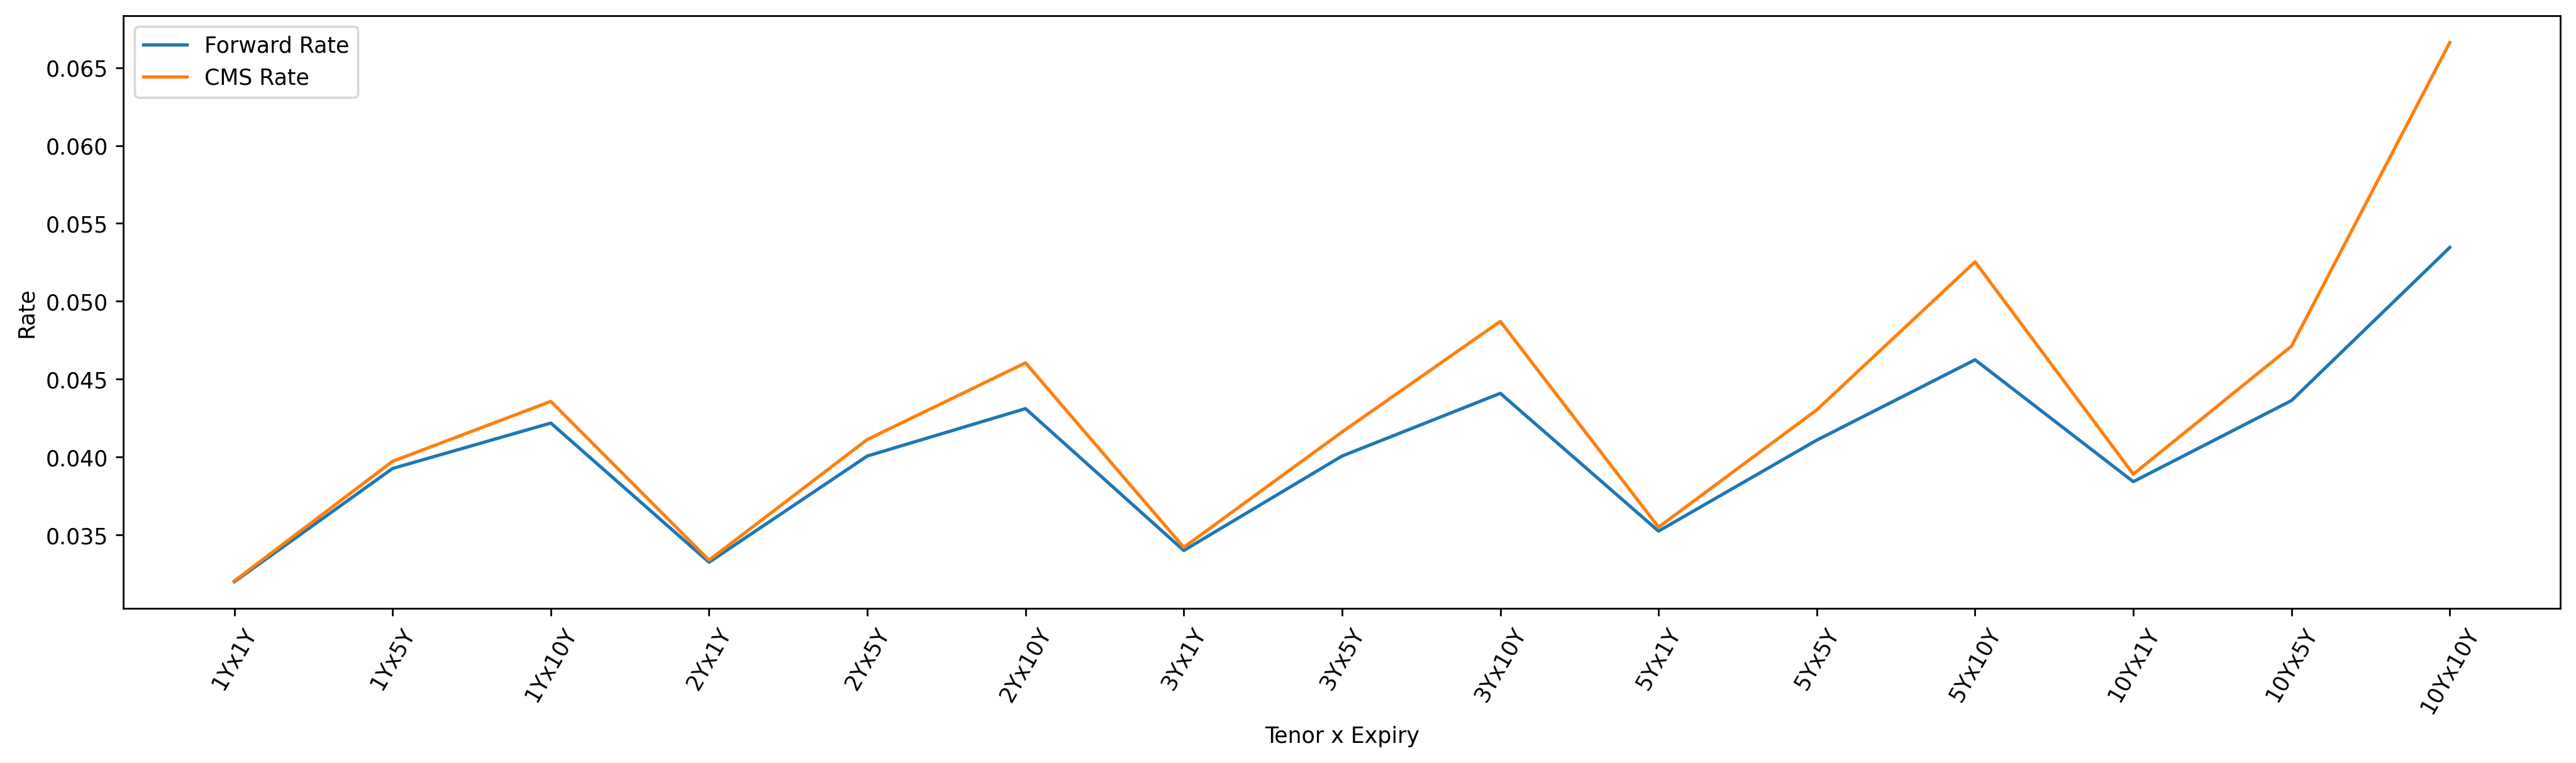

In [72]:
plt.figure(dpi=250, figsize=(20,5))
plt.plot(x_axis_forward,y_axis_forward,label='Forward Rate')
plt.plot(x_axis_cms, y_axis_cms,label='CMS Rate')
plt.xlabel('Tenor x Expiry')
plt.xticks(rotation=60)
plt.ylabel('Rate')
plt.legend()
plt.show()

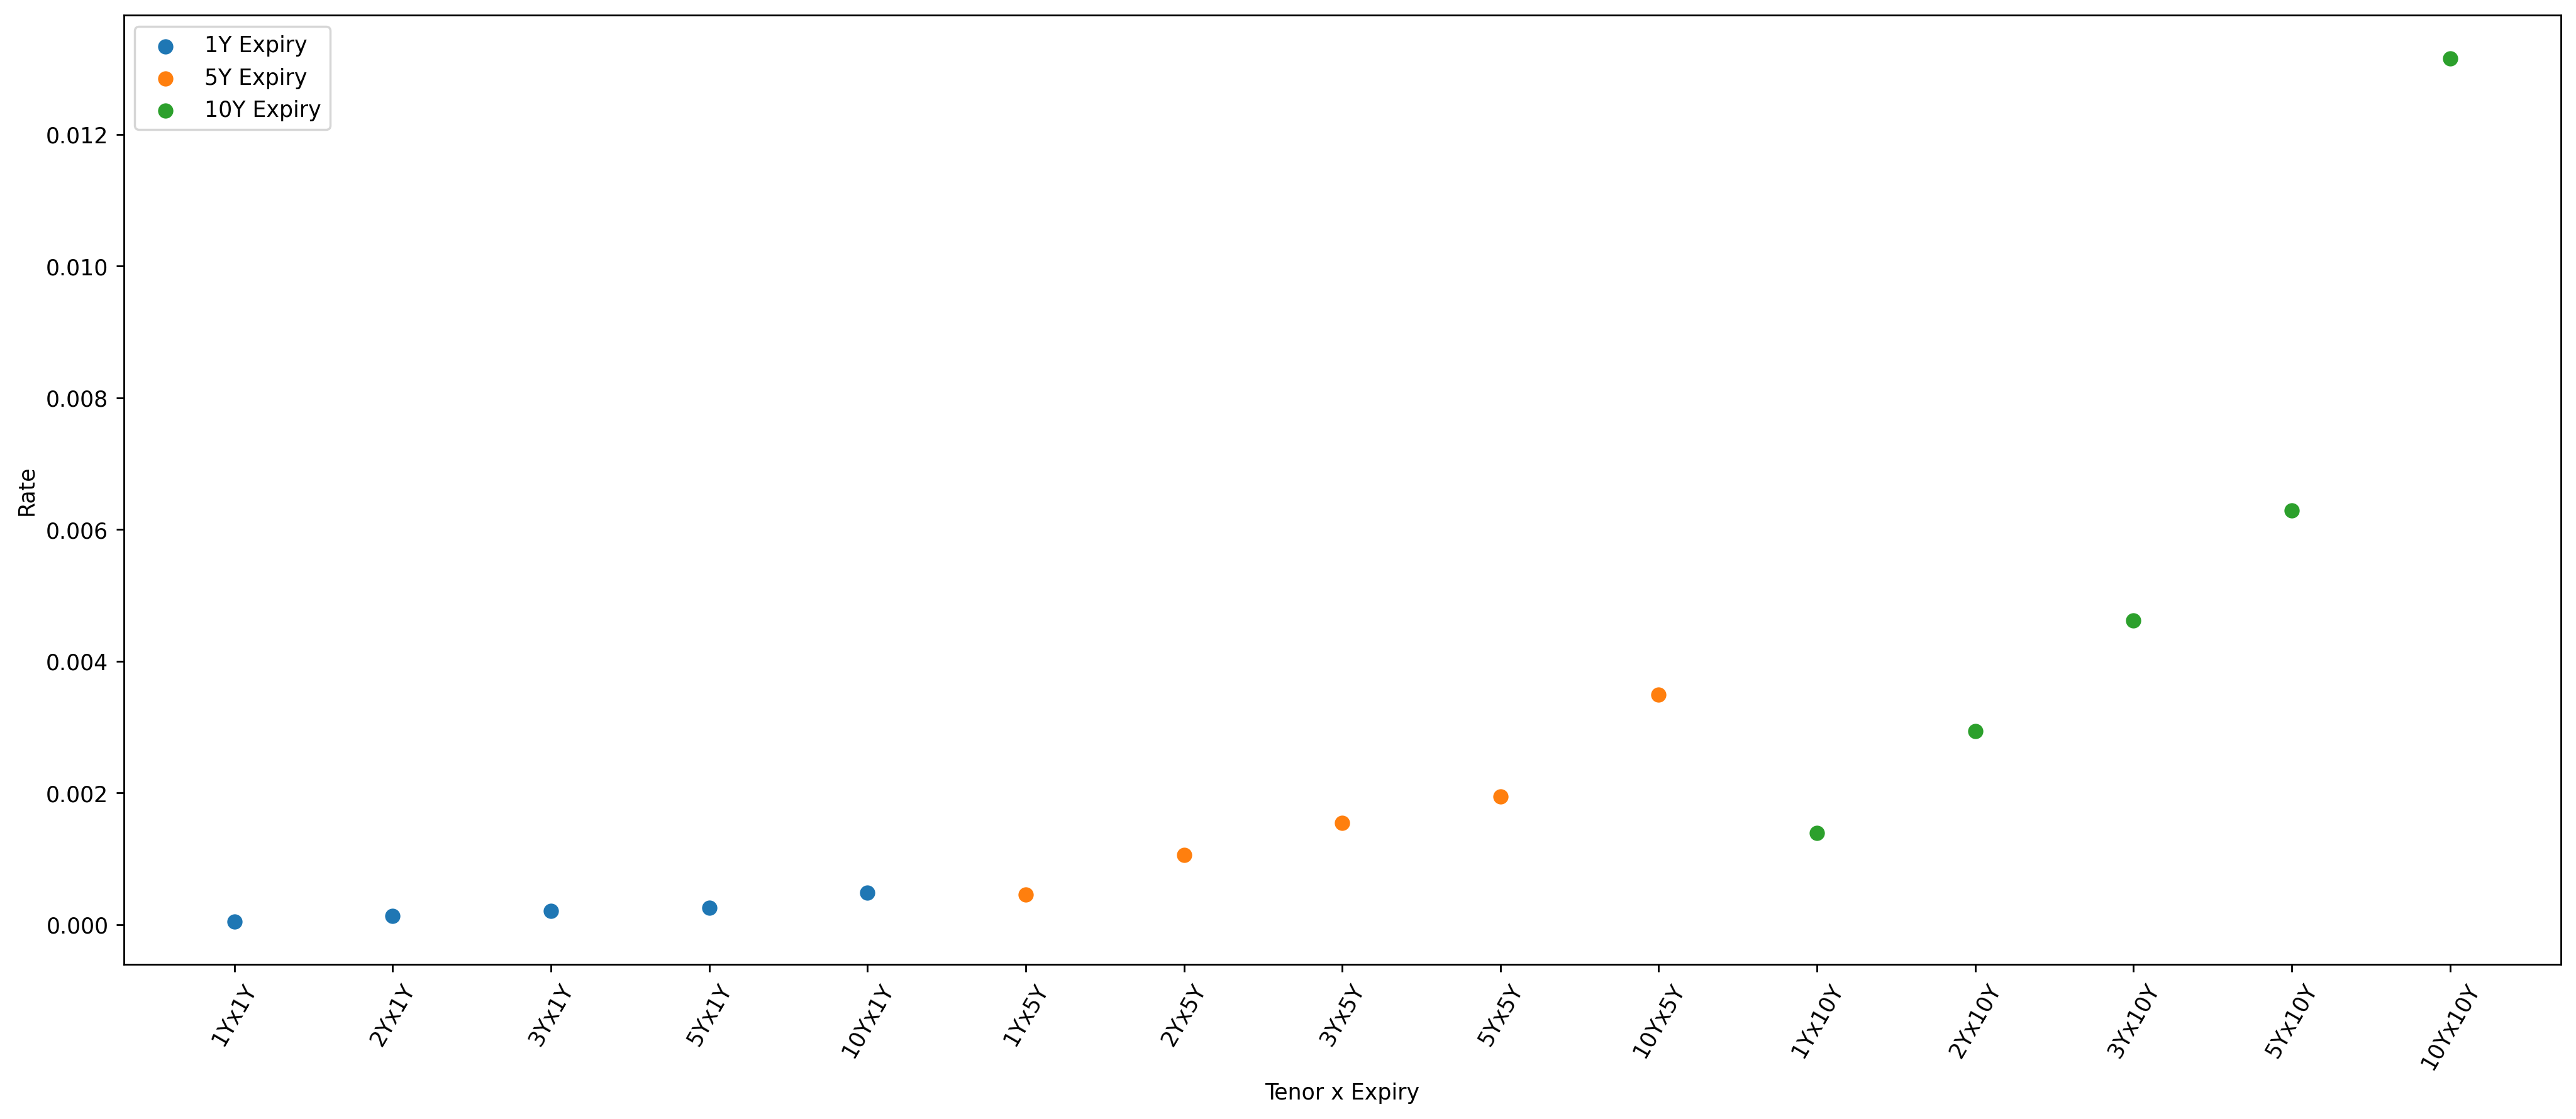

In [73]:
plt.figure(dpi=250, figsize=(20,8))
plt.scatter(x_axis_diff[::3],y_axis_diff[::3],label='1Y Expiry')
plt.scatter(x_axis_diff[1::3],y_axis_diff[1::3],label='5Y Expiry')
plt.scatter(x_axis_diff[2::3],y_axis_diff[2::3],label='10Y Expiry')
plt.xlabel('Tenor x Expiry')
plt.xticks(rotation=60)
plt.ylabel('Rate')
plt.legend()
plt.show()

### Export Data

In [74]:
# with pd.ExcelWriter('Data_3_Output.xlsx', engine='openpyxl', mode='a') as writer:
#     pv_cms_2x10.to_excel(writer, sheet_name='CMS 2x10',index=True)
#     pv_cms_10x5.to_excel(writer, sheet_name='CMS 10x5',index=True)  

ValueError: Sheet 'CMS 2x10' already exists and if_sheet_exists is set to 'error'.